In [4]:
from tinytensor.engine import Tensor
from tinytensor.nn import Model, Conv2d, MaxPool,Softmax, sgd, categorical_cross_entropy
import numpy as np
from tensorflow import keras #for easily getting MNIST data
from matplotlib import pyplot as plt
np.random.seed(1337)

## Import data

Actual Value: 5


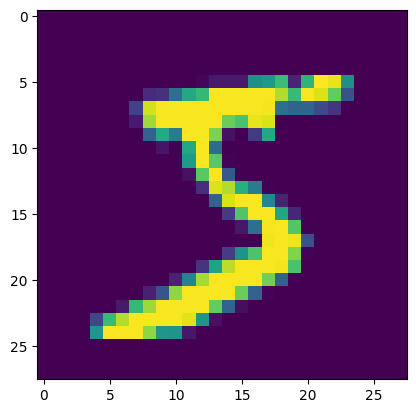

In [9]:
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = keras.datasets.mnist.load_data()

num_classes = 10
number_samples = 5000
image_shape = (1,28,28,1)
X_train_trim,y_train_trim = X_train_raw[:number_samples],y_train_raw[:number_samples]

X_train = X_train_trim.reshape(number_samples,28,28,1) / 255
y_train = keras.utils.to_categorical(y_train_trim, num_classes)

i = 0
print(f"Actual Value: {y_train_raw[0]}")
plt.imshow(X_train_raw[0])
plt.show()

## Initialize model

In [10]:
kernel_shape = (16,3,3,1) #16 kernels of shape 3x3 with a depth of 1 (black & white)
max_pool_shape = (16,2,2) #receives the 16 kernels from the conv layer with a 2x2 pooling window

conv = Conv2d(kernel_shape,image_shape)
pool = MaxPool(max_pool_shape,conv.output_shape())
softmax = Softmax(pool.output_shape(),num_classes)

layers = [conv,pool,softmax]

initial_model = Model(layers = layers)

## Loss & Training Functions

In [31]:
def loss(model: Model,data: tuple,learning_rate: float) -> Model:
    x,y = data[0],data[1]
    yhat = model(x)
    data_loss = categorical_cross_entropy(y,yhat)
    data_loss.backward()
    grads = [layer.grads() for layer in model.layers]
    new_layers = [sgd(layer,grad,learning_rate) for layer,grad in zip(model.layers,grads)]
    new_model = Model(layers = new_layers)
    is_correct = 1 if np.argmax(y.data) == np.argmax(yhat.data) else 0
    return new_model,np.round(data_loss.data.reshape(()),6),is_correct


def train(model,X_train,y_train,epochs,learning_rate):

    current_model = model
    accuracy = 0
    avg_data_losses = []
    data_losses = 0
    sample_size = 100
    for k in range(epochs):
        permutation_indices = np.random.permutation(X_train.shape[0])
        X = (Tensor(x.reshape(image_shape)) for x in X_train[permutation_indices])
        y = [Tensor(y.reshape(1,10)) for y in y_train[permutation_indices]]

        for i,data in enumerate(zip(X,y)):
            new_model,data_loss,is_correct = loss(current_model,data,learning_rate)
            accuracy += is_correct
            data_losses += data_loss
            current_model = new_model

            if (i + 1) % sample_size == 0:
                avg_data_losses.append(round(data_losses / sample_size,6))
                print(f"finished training epoch: {k}; image: {i + 1}; avg of last {sample_size} losses = {round(data_losses / sample_size,6)}; accuracy = {accuracy / sample_size * 100}%")
                accuracy, data_losses = 0,0

    return current_model,avg_data_losses

# Training the model

In [32]:
epochs = 4
learning_rate = 1e-2

final_model,avg_data_losses = train(initial_model,X_train,y_train,epochs,learning_rate)

finished training epoch: 0; image: 100; avg of last 100 losses = 2.087531; accuracy = 37.0%
finished training epoch: 0; image: 200; avg of last 100 losses = 1.628055; accuracy = 52.0%
finished training epoch: 0; image: 300; avg of last 100 losses = 1.036325; accuracy = 62.0%
finished training epoch: 0; image: 400; avg of last 100 losses = 0.775795; accuracy = 78.0%
finished training epoch: 0; image: 500; avg of last 100 losses = 0.763023; accuracy = 72.0%
finished training epoch: 0; image: 600; avg of last 100 losses = 0.705405; accuracy = 75.0%
finished training epoch: 0; image: 700; avg of last 100 losses = 0.694408; accuracy = 79.0%
finished training epoch: 0; image: 800; avg of last 100 losses = 0.371507; accuracy = 88.0%
finished training epoch: 0; image: 900; avg of last 100 losses = 0.593292; accuracy = 82.0%
finished training epoch: 0; image: 1000; avg of last 100 losses = 0.423893; accuracy = 83.0%
finished training epoch: 0; image: 1100; avg of last 100 losses = 0.47154; accu

It works! (Ok, I've only demonstrated so far that it converges on training data. But the point is to show that a CNN is working on the tinytensor autograd engine, not to produce an optimal CNN).